In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

sns.set()

from IPython.display import display
from tools import make_track, ols_regression
from hc_graph import hc_stock

### Financial data loads and cleaning

In [3]:
# BNP Data
#bnp = pd.read_csv(r'financial_data/bnp_data.csv', parse_dates =True, sep=";", header= [3], index_col=0)
#bnp_wanted_ticker = ["US_USDLIBOR3M","USD_EUR"]
#bnp

In [4]:
# yahoo_prices
yahoo = pd.read_csv(r"financial_data/yahoo_prices.csv", index_col=0, parse_dates=True)

# MSCI
msci = pd.read_csv(r'financial_data/msci_data.csv', index_col=0, parse_dates=True, sep=";")

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, sep=";")
hfrx = hfrx_all[hfrx_all['Name'] == 'HFRXEMN'][["Price"]].rename(columns={'Price':"HFRXEMN"})

In [5]:
prices = yahoo.copy()
#prices = prices.join(msci, how="outer")
prices = prices.join(hfrx,how="outer")

In [6]:
prices.head()

,FSTEMIB,CAC 40,DAX,SP 500,IBEX,SX5E,HFRXEMN
2000-01-03,41226.0,5917.370117,6750.759766,1455.219971,11610.000000,4849.220215,NaN
2000-01-04,40314.0,5672.020020,6586.950195,1399.420044,11206.599609,4657.830078,NaN
2000-01-05,39452.0,5479.700195,6502.069824,1402.109985,10863.099609,4541.750000,NaN
2000-01-06,38835.0,5450.109863,6474.919922,1403.449951,10863.099609,4500.689941,NaN
2000-01-07,40194.0,5539.609863,6780.959961,1441.469971,11102.400391,4648.270020,NaN


In [7]:
starts = prices.apply(lambda x:x.first_valid_index())
starts.T

FSTEMIB   2000-01-03
CAC 40    2000-01-03
DAX       2000-01-03
SP 500    2000-01-03
IBEX      2000-01-03
SX5E      2000-01-03
HFRXEMN   2003-03-31
dtype: datetime64[ns]

In [8]:
prices = prices[starts.max():].ffill()
returns = prices.resample('7D').apply(lambda x:x[0]).pct_change().dropna()
returns.head()

,FSTEMIB,CAC 40,DAX,SP 500,IBEX,SX5E,HFRXEMN
2003-04-07,0.081416,0.121148,0.158866,0.037433,0.099429,0.136328,-0.005710
2003-04-14,-0.004665,-0.020677,-0.011449,0.006023,0.005330,-0.017533,0.000282
2003-04-21,0.013502,0.008219,0.044296,0.007659,0.013223,0.022124,-0.005982
2003-04-28,0.014638,0.017581,0.018670,0.025594,0.005080,0.008497,0.001204
2003-05-05,0.008029,0.015816,0.020014,0.012800,-0.017631,0.003255,0.000707


In [9]:
hrfx_returns = returns[["HFRXEMN"]]
bch_returns = returns.drop("HFRXEMN", axis=1)

size = 52
freq = 13
bounds = (-np.inf,np.inf)
total_weight = 1

df_weight = ols_regression(hrfx_returns, bch_returns, size, freq, boundaries=bounds, weight_sum=total_weight)

prices_for_track = prices.loc[df_weight.index[0]:].drop("HFRXEMN", axis=1)
replication = make_track(prices_for_track, df_weight)

df_res = prices.loc[replication.index][["HFRXEMN"]]
df_res["OLS"] = replication

df_res = df_res / df_res.iloc[0]

df_res.head()

,HFRXEMN,OLS
2004-04-05,1.000000,1.000000
2004-04-06,1.000848,1.005817
2004-04-07,1.000531,1.004801
2004-04-08,0.996630,1.010111
2004-04-09,0.996630,1.010111


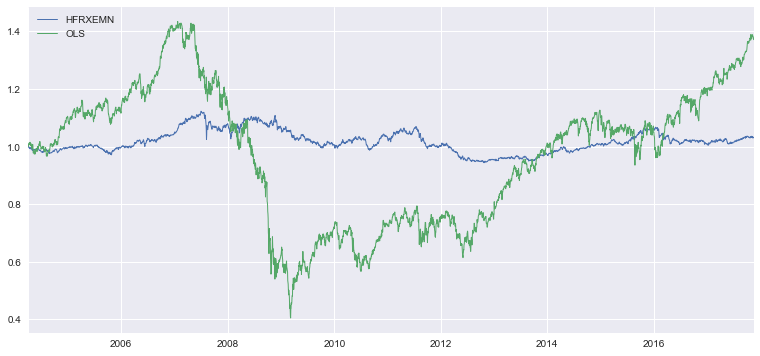

In [14]:
df_res.plot(figsize=(13,6), linewidth=1)

In [11]:
g = hc_stock(df_res)
g.plot()